In [4]:
import cv2
import numpy as np
from tqdm import tqdm

def load_images(image_folder):
    import os
    images = []
    for filename in sorted(os.listdir(image_folder)):
        if filename.endswith((".JPG", ".png", ".tif")):
            img = cv2.imread(os.path.join(image_folder, filename))
            if img is not None:
                images.append(img)
    return images

def detect_and_match_features(img1, img2):
    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    return src_pts, dst_pts

def stitch_images(images):
    base_image = images[0]
    for i in  tqdm(range(1, len(images)), desc="Image"):
        src_pts, dst_pts = detect_and_match_features(base_image, images[i])
        H, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
        height, width, _ = base_image.shape
        warped_image = cv2.warpPerspective(images[i], H, (width, height))
        mask = (warped_image > 0).astype(np.uint8)
        base_image = cv2.add(base_image * (1 - mask), warped_image * mask)
    return base_image

# Directorio de imágenes
image_folder = "./data/trees-avocado/m3m/campo2/images"
output_path = "ortomosaico.jpg"

# Cargar imágenes
images = load_images(image_folder)

# Generar ortomosaico
ortomosaico = stitch_images(images)

# Guardar el ortomosaico
cv2.imwrite(output_path, ortomosaico)
print("Ortomosaico generado y guardado en:", output_path)

ModuleNotFoundError: No module named 'tqdm'

In [6]:
import cv2
import numpy as np

def load_images(image_folder):
    import os
    images = []
    for filename in sorted(os.listdir(image_folder)):
        if filename.endswith((".JPG", ".png", ".tif")):
            img = cv2.imread(os.path.join(image_folder, filename))
            if img is not None:
                images.append(img)
    return images

def preprocess_image(img):
    # Convertir a escala de grises
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Aplicar CLAHE para normalizar la iluminación
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(gray)

def detect_and_match_features(img1, img2):
    # Usar SIFT para detectar puntos clave
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # Emparejar características con FLANN
    index_params = dict(algorithm=1, trees=5)  # FLANN con KD-Tree
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # Aplicar el ratio test de Lowe
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    # Extraer puntos emparejados
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    return src_pts, dst_pts

def stitch_images(images):
    # Usar la primera imagen como base
    base_image = images[0]
    base_image_gray = preprocess_image(base_image)

    for i in range(1, len(images)):
        print(f"Procesando imagen {i + 1} de {len(images)}...")
        next_image = images[i]
        next_image_gray = preprocess_image(next_image)

        # Detectar y emparejar características
        src_pts, dst_pts = detect_and_match_features(base_image_gray, next_image_gray)

        # Calcular homografía
        H, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

        # Warpear la siguiente imagen al espacio de la base
        height, width, _ = base_image.shape
        warped_image = cv2.warpPerspective(next_image, H, (width, height))

        # Combinar imágenes suavemente
        base_image = np.maximum(base_image, warped_image)

    return base_image

# Directorio de imágenes
image_folder = "./data/trees-avocado/m3m/campo2/images"
output_path = "ortomosaico_cultivos.jpg"

# Cargar imágenes
images = load_images(image_folder)

# Generar ortomosaico
ortomosaico = stitch_images(images)

# Guardar el ortomosaico
cv2.imwrite(output_path, ortomosaico)
print("Ortomosaico generado y guardado en:", output_path)

Procesando imagen 2 de 50...
Procesando imagen 3 de 50...
Procesando imagen 4 de 50...
Procesando imagen 5 de 50...
Procesando imagen 6 de 50...
Procesando imagen 7 de 50...
Procesando imagen 8 de 50...
Procesando imagen 9 de 50...
Procesando imagen 10 de 50...
Procesando imagen 11 de 50...
Procesando imagen 12 de 50...
Procesando imagen 13 de 50...
Procesando imagen 14 de 50...
Procesando imagen 15 de 50...
Procesando imagen 16 de 50...
Procesando imagen 17 de 50...
Procesando imagen 18 de 50...
Procesando imagen 19 de 50...
Procesando imagen 20 de 50...
Procesando imagen 21 de 50...
Procesando imagen 22 de 50...
Procesando imagen 23 de 50...
Procesando imagen 24 de 50...
Procesando imagen 25 de 50...
Procesando imagen 26 de 50...
Procesando imagen 27 de 50...
Procesando imagen 28 de 50...
Procesando imagen 29 de 50...
Procesando imagen 30 de 50...
Procesando imagen 31 de 50...
Procesando imagen 32 de 50...
Procesando imagen 33 de 50...
Procesando imagen 34 de 50...
Procesando imagen 

Imagen 1: 622655 puntos clave detectados


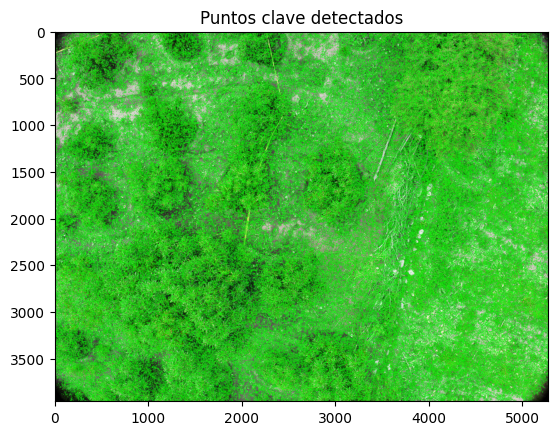

622655 matches encontrados
Imagen 1 - Imagen 2: 53462 emparejamientos buenos encontrados


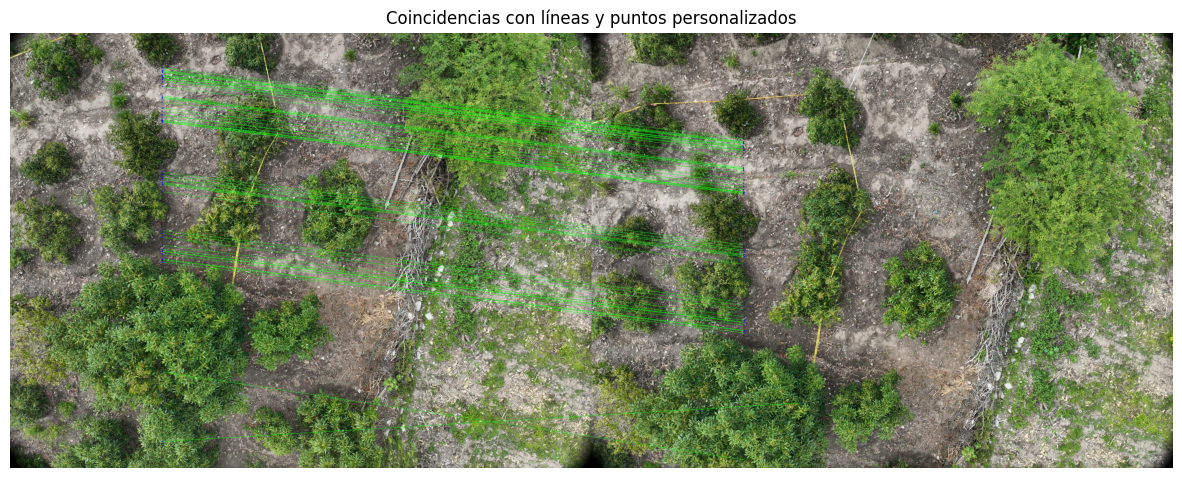

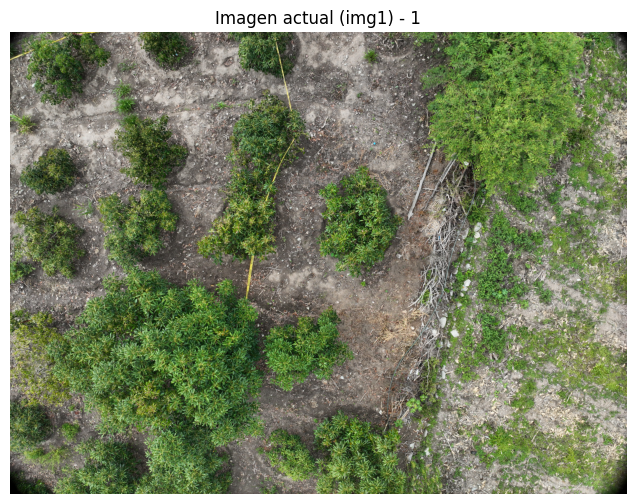

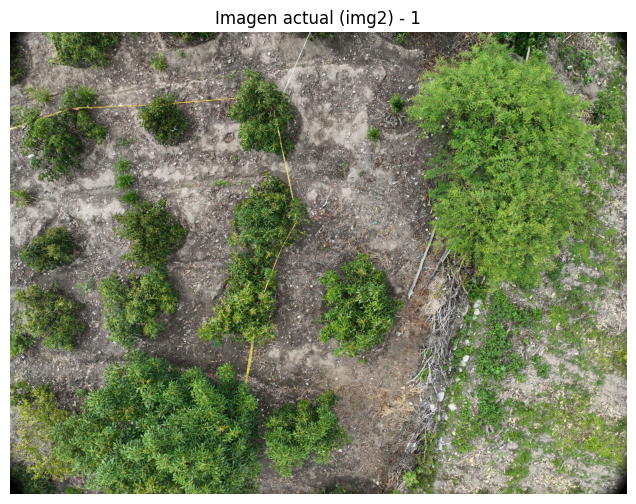

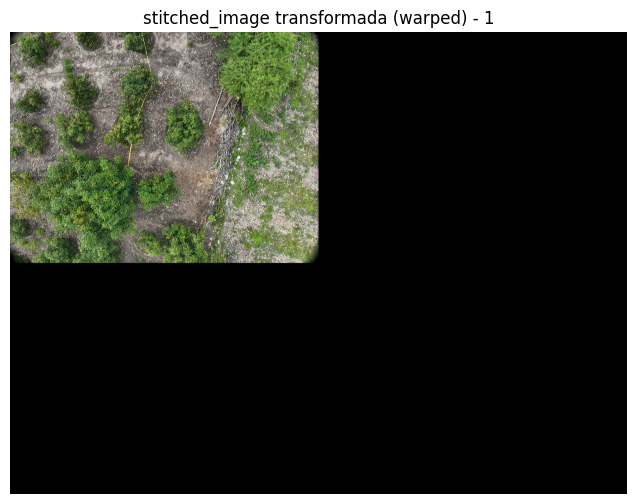

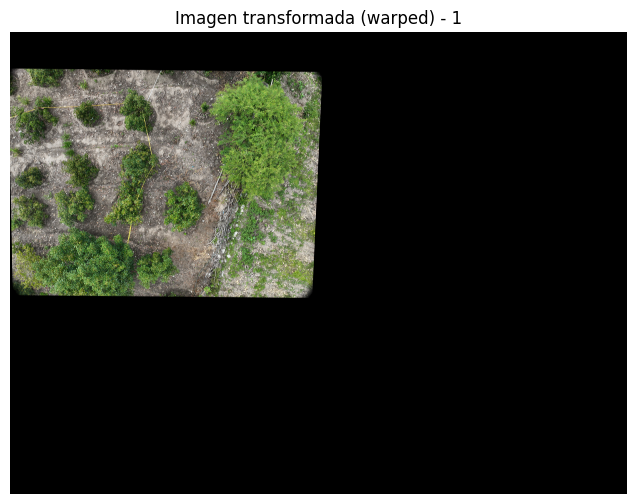

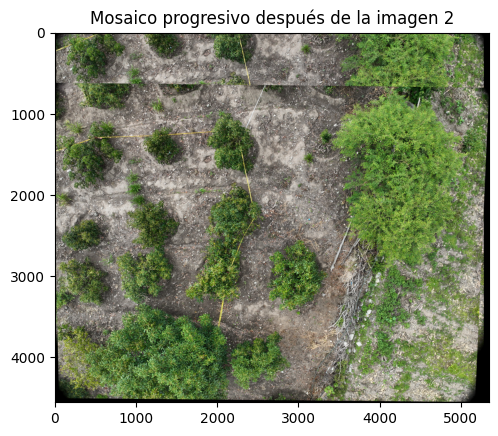

Ortomosaico generado y guardado como 'ortomosaico_flann.jpg'


In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

# Lista de imágenes (reemplaza con tus imágenes)
images = ["img1.jpg", "img2.jpg", "img3.jpg"]

# Visualización sencilla
def show_image(title, img):
    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

def draw_matches_with_custom_thickness(img1, kp1, img2, kp2, matches, line_thickness=2, point_radius=5):
    """
    Dibuja coincidencias entre dos imágenes con líneas y puntos personalizados.

    Args:
    - img1: Primera imagen.
    - kp1: Puntos clave de la primera imagen.
    - img2: Segunda imagen.
    - kp2: Puntos clave de la segunda imagen.
    - matches: Lista de coincidencias.
    - line_thickness: Grosor de las líneas que conectan los puntos.
    - point_radius: Radio de los puntos clave.
    """
    # Asegurarse de que las imágenes tengan 3 canales (color)
    if len(img1.shape) == 2:  # Imagen en escala de grises
        img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    if len(img2.shape) == 2:  # Imagen en escala de grises
        img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)

    # Crear una imagen combinada de las dos imágenes
    height1, width1 = img1.shape[:2]
    height2, width2 = img2.shape[:2]
    combined_img = np.zeros((max(height1, height2), width1 + width2, 3), dtype=np.uint8)
    combined_img[:height1, :width1] = img1
    combined_img[:height2, width1:] = img2

    # Dibujar coincidencias
    for match in matches:
        # Obtener los puntos de coincidencia
        pt1 = tuple(map(int, kp1[match.queryIdx].pt))
        pt2 = tuple(map(int, kp2[match.trainIdx].pt))
        pt2 = (pt2[0] + width1, pt2[1])  # Ajustar coordenadas para la segunda imagen

        # Dibujar línea entre los puntos
        cv2.line(combined_img, pt1, pt2, (0, 255, 0), thickness=line_thickness)

        # Dibujar círculos en los puntos clave
        cv2.circle(combined_img, pt1, point_radius, (255, 0, 0), -1)
        cv2.circle(combined_img, pt2, point_radius, (255, 0, 0), -1)

    # Mostrar la imagen combinada
    plt.figure(figsize=(15, 8))
    plt.imshow(cv2.cvtColor(combined_img, cv2.COLOR_BGR2RGB))
    plt.title("Coincidencias con líneas y puntos personalizados")
    plt.axis("off")
    plt.show()
    
# Visualizar puntos clave
def visualize_keypoints(image, keypoints):
    img_with_keypoints = cv2.drawKeypoints(image, keypoints, None, color=(0, 255, 0))
    plt.imshow(cv2.cvtColor(img_with_keypoints, cv2.COLOR_BGR2RGB))
    plt.title("Puntos clave detectados")
    plt.show()

# Visualizar emparejamientos
def visualize_matches(img1, kp1, img2, kp2, matches):
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(15, 8))
    plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
    plt.title("Emparejamiento de puntos clave")
    plt.show()

# Detectar y describir características
def detect_and_describe(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

# Emparejar características usando FlannBasedMatcher
def match_features_flann(des1, des2):
    # Configuración del índice y parámetros del buscador FLANN
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)  # Número de iteraciones para mejorar la precisión

    # Crear el objeto FlannBasedMatcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    # Encontrar coincidencias
    matches = flann.knnMatch(des1, des2, k=2)
    
    print(f"{len(matches)} matches encontrados")
    # Aplicar ratio test de Lowe
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:  # Umbral de ratio
            good_matches.append(m)
    return good_matches

folder_path = "./data/trees-avocado/m3m/campo2/images/"

jpg_files = glob(f"{folder_path}/*.JPG")

images = jpg_files

# Cargar las imágenes y procesarlas
stitched_image = None
for i in range(len(images) - 1):
    img1 = cv2.imread(images[i], cv2.IMREAD_COLOR)
    img2 = cv2.imread(images[i + 1], cv2.IMREAD_COLOR)
    
    # Convertir a escala de grises
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    # Detectar características
    kp1, des1 = detect_and_describe(gray1)
    kp2, des2 = detect_and_describe(gray2)
    
    # Visualizar puntos clave
    print(f"Imagen {i+1}: {len(kp1)} puntos clave detectados")
    visualize_keypoints(img1, kp1)
    
    # Emparejar características
    matches = match_features_flann(des1, des2)
    print(f"Imagen {i+1} - Imagen {i+2}: {len(matches)} emparejamientos buenos encontrados")
    
    # Visualizar emparejamientos
    draw_matches_with_custom_thickness(img1, kp1, img2, kp2, matches[10000:10050])  # Mostrar los primeros 50 emparejamientos
    
    # Calcular homografía
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
    # Transformar la imagen actual al lienzo combinado
    h1, w1, _ = img1.shape
    h2, w2, _ = img2.shape

     # Mostrar la imagen actual
    show_image(f"Imagen actual (img1) - {i+1}", img1)
    show_image(f"Imagen actual (img2) - {i+1}", img2)
    
    # Crear lienzo dinámico
    if stitched_image is None:
        h1, w1, _ = img1.shape
        stitched_image = np.zeros((h1 + h2, w1 + w2, 3), dtype=np.uint8)  # Tres canales para imágenes en color
        stitched_image[:h1, :w1] = img1
    show_image(f"stitched_image transformada (warped) - {i+1}", stitched_image)
     # Transformar img2 al espacio de img1
    h2, w2, _ = img2.shape
    warped_img2 = cv2.warpPerspective(img2, H, (stitched_image.shape[1], stitched_image.shape[0]))

    show_image(f"Imagen transformada (warped) - {i+1}", warped_img2)

    # Crear una máscara para img2
    mask = np.zeros((h2, w2), dtype=np.uint8)
    mask[:h2, :w2] = 255
    warped_mask = cv2.warpPerspective(mask, H, (stitched_image.shape[1], stitched_image.shape[0]))

    # Combinar imágenes utilizando la máscara para cada canal
    for c in range(3):  # Canales B, G, R
        stitched_image[:, :, c] = cv2.bitwise_and(stitched_image[:, :, c], cv2.bitwise_not(warped_mask))
        stitched_image[:, :, c] = cv2.add(stitched_image[:, :, c], warped_img2[:, :, c])

    # Recortar áreas vacías para evitar dimensiones excesivas
    non_empty_rows = np.any(stitched_image != 0, axis=(1, 2))
    non_empty_cols = np.any(stitched_image != 0, axis=(0, 2))
    min_row, max_row = np.where(non_empty_rows)[0][[0, -1]]
    min_col, max_col = np.where(non_empty_cols)[0][[0, -1]]
    stitched_image = stitched_image[min_row:max_row+1, min_col:max_col+1]

    plt.imshow(cv2.cvtColor(stitched_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Mosaico progresivo después de la imagen {i+2}")
    plt.show()
    break

# Guardar el mosaico final
cv2.imwrite("ortomosaico_flann.jpg", stitched_image)
print("Ortomosaico generado y guardado como 'ortomosaico_flann.jpg'")
